In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [11]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
import os
import feather
import math
import re

In [5]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

In [6]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Helper Functions

In [8]:
def get_samples(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def rf_feature_imp(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples: 
                                       forest.check_random_state(rs).randint(0, n_samples, n))
    
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples: 
                                       forest.check_random_state(rs).randint(0, n_samples, n_samples))
    
    
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
            
def apply_cats(df, trn):
    for n, c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            
            
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
        
        
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()


def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n], StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_name_] = mapper.transform(df)
    return mapper


def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories) > max_n_cat):
        df[name] = col.cat.codes+1
        
        
def proc_df(df, y_fld, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if not ignore_flds: ignore_flds=[]
    if subset:
        df = get_sample(df, subset)
    else:
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn:
        preproc_fn(df)
    if y_fld is None:
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]):
            df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    
    if na_dict is None:
        na_dict = {}
    else:
        na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n, c in df.items():
        na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale:
        mapper = scale_vars(df, mapper)
    for n, c in df.items():
        numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale:
        res = res + mapper
    return res

def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

def rmse(x, y):
    return math.sqrt(((x - y)**2).mean())

def print_score(m, X_train, y_train, X_test, y_test):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [7]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size = {size}; ratio={ratio}', s)))

# Load Data

In [9]:
PATH = "data/bulldozers/"

df_raw = feather.read_dataframe('tmp/bulldozer-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [10]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200


In [27]:
m = GradientBoostingRegressor(n_estimators=100)
m.fit(df_trn, y_trn)
m.score(df_trn, y_trn)

0.8017823854758173

In [28]:
n_valid = 12000
n_trn = len(df_trn)- n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [30]:
m = GradientBoostingRegressor(n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 11 s, sys: 460 ms, total: 11.5 s
Wall time: 11.5 s
[0.5089425750884575, 0.5355760055693654, 0.4586571664677354, 0.48774029184443113]


In [38]:
m = GradientBoostingRegressor(n_estimators=1, max_depth=3)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.6651210850458256, 0.7203661647382101, 0.07543753663491681, 0.07326708972756302]


In [41]:
m.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x105d675a0>,
           splitter='best')

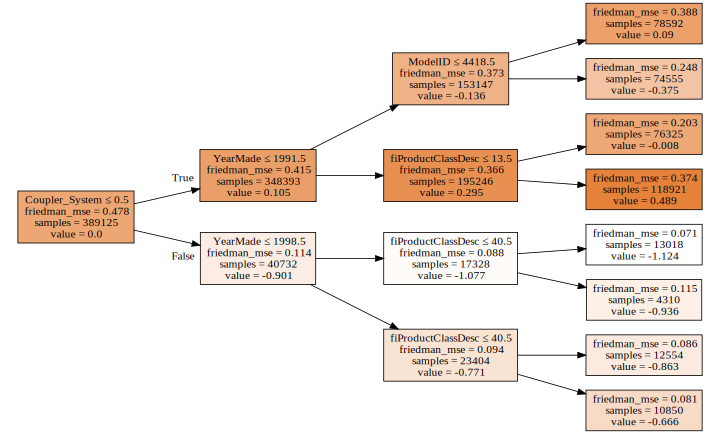

In [42]:
draw_tree(m.estimators_[0][0], df_trn, precision=3)

In [45]:
m = GradientBoostingRegressor(n_estimators=1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.6651210850458255, 0.7203661647382098, 0.07543753663491715, 0.07326708972756368]


In [46]:
m = GradientBoostingRegressor(n_estimators=10)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.5089425750884573, 0.5355760055693654, 0.4586571664677359, 0.48774029184443113]


In [47]:
preds = np.stack([t[0].predict(X_valid) for t in m.estimators_])
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([ 0.4892 ,  0.36318,  0.40396,  0.28611,  0.12651, -0.19826, -0.36603, -0.59378, -0.30231, -0.51108]),
 -0.030250902172765833,
 9.104979856318357)